In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import netCDF4 as nc
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from netCDF4 import Dataset
import wrf
from wrf import getvar, ALL_TIMES, latlon_coords
import xarray as xr

### Land cover datafiles

In [2]:
data_24_def = [Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_WRFDef_2024_4/wrfout_d02_2024-02-10_21:00:00'),
Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_WRFDef_2024_4/wrfout_d02_2024-02-11_21:00:00'),
Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_WRFDef_2024_4/wrfout_d02_2024-02-11_21:10:00'),
Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_WRFDef_2024_4/wrfout_d02_2024-02-12_21:10:00')]
data_24_gr = [Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_GrUrban_2024_4/wrfout_d02_2024-02-10_21:00:00'),
Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_GrUrban_2024_4/wrfout_d02_2024-02-10_22:00:00'),
Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_GrUrban_2024_4/wrfout_d02_2024-02-11_21:10:00'),
Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_GrUrban_2024_4/wrfout_d02_2024-02-12_21:10:00')]

In [3]:
def gr_coastline():
    grland = wrf.getvar(data_24_gr, 'LU_INDEX', timeidx=0, method='cat')
    wat = np.where(grland != 17, 0, grland)
    water = np.where(wat == 17, 1, wat)
    water[0:290, 0:130] = 0 
    water[26:290, 0:156] = 0
    water[26:33, 0:157] = 0 
    water[25:30, 0:156] = 0
    water[47:49, 0:167] = 0
    water[80:160, 0:175] = 0
    water[95:160, 0:177] = 0
    water[120:190, 0:182] = 0
    water[132:190, 0:186] = 0
    water[150:154, 0:203] = 0
    water[168:172, 0:214] = 0
    water[190:210, 0:215] = 0
    water[192:200, 0:218] = 0
    water[210:290, 0:225] = 0
    water[220:290, 0:233] = 0
    water[225:290, 0:236] = 0
    water[230:290, 0:237] = 0
    water[232:290, 0:241] = 0
    water[229:290, 0:237] = 0
    water[242:290, 0:245] = 0
    water[251:290, 0:250] = 0
    water[278:290, 0:266] = 0
    return water

def def_urb_outline():
    defland = wrf.getvar(data_24_def, 'LU_INDEX', timeidx=0, method='cat')
    urb = np.where(defland != 13, 0, defland) #set everything that isn't urban to zero
    uniurb = np.where(urb == 13, 1, urb) #make urban area uniform
    return uniurb

def urb_outline():
    grland = wrf.getvar(data_24_gr, 'LU_INDEX', timeidx=0, method='cat')
    urb = np.where(grland <= 49, 0, grland) #set everything that isn't urban to zero
    uniurb = np.where(urb >= 49, 1, urb) #make urban area uniform
    return uniurb

def met_outline():
    grland = wrf.getvar(data_24_gr, 'LU_INDEX', timeidx=8, method='cat')
    urb = np.where(grland <= 49, 0, grland) #set everything that isn't urban to zero
    urb[0:140, 0:200] = 0 # area below Sydney
    urb[0:289, 0:150] = 0 # left of Sydney
    urb[205:289, 0:279] = 0 # left of Sydney
    uniurb = np.where(urb >= 49, 1, urb) #make urban area uniform
    return uniurb

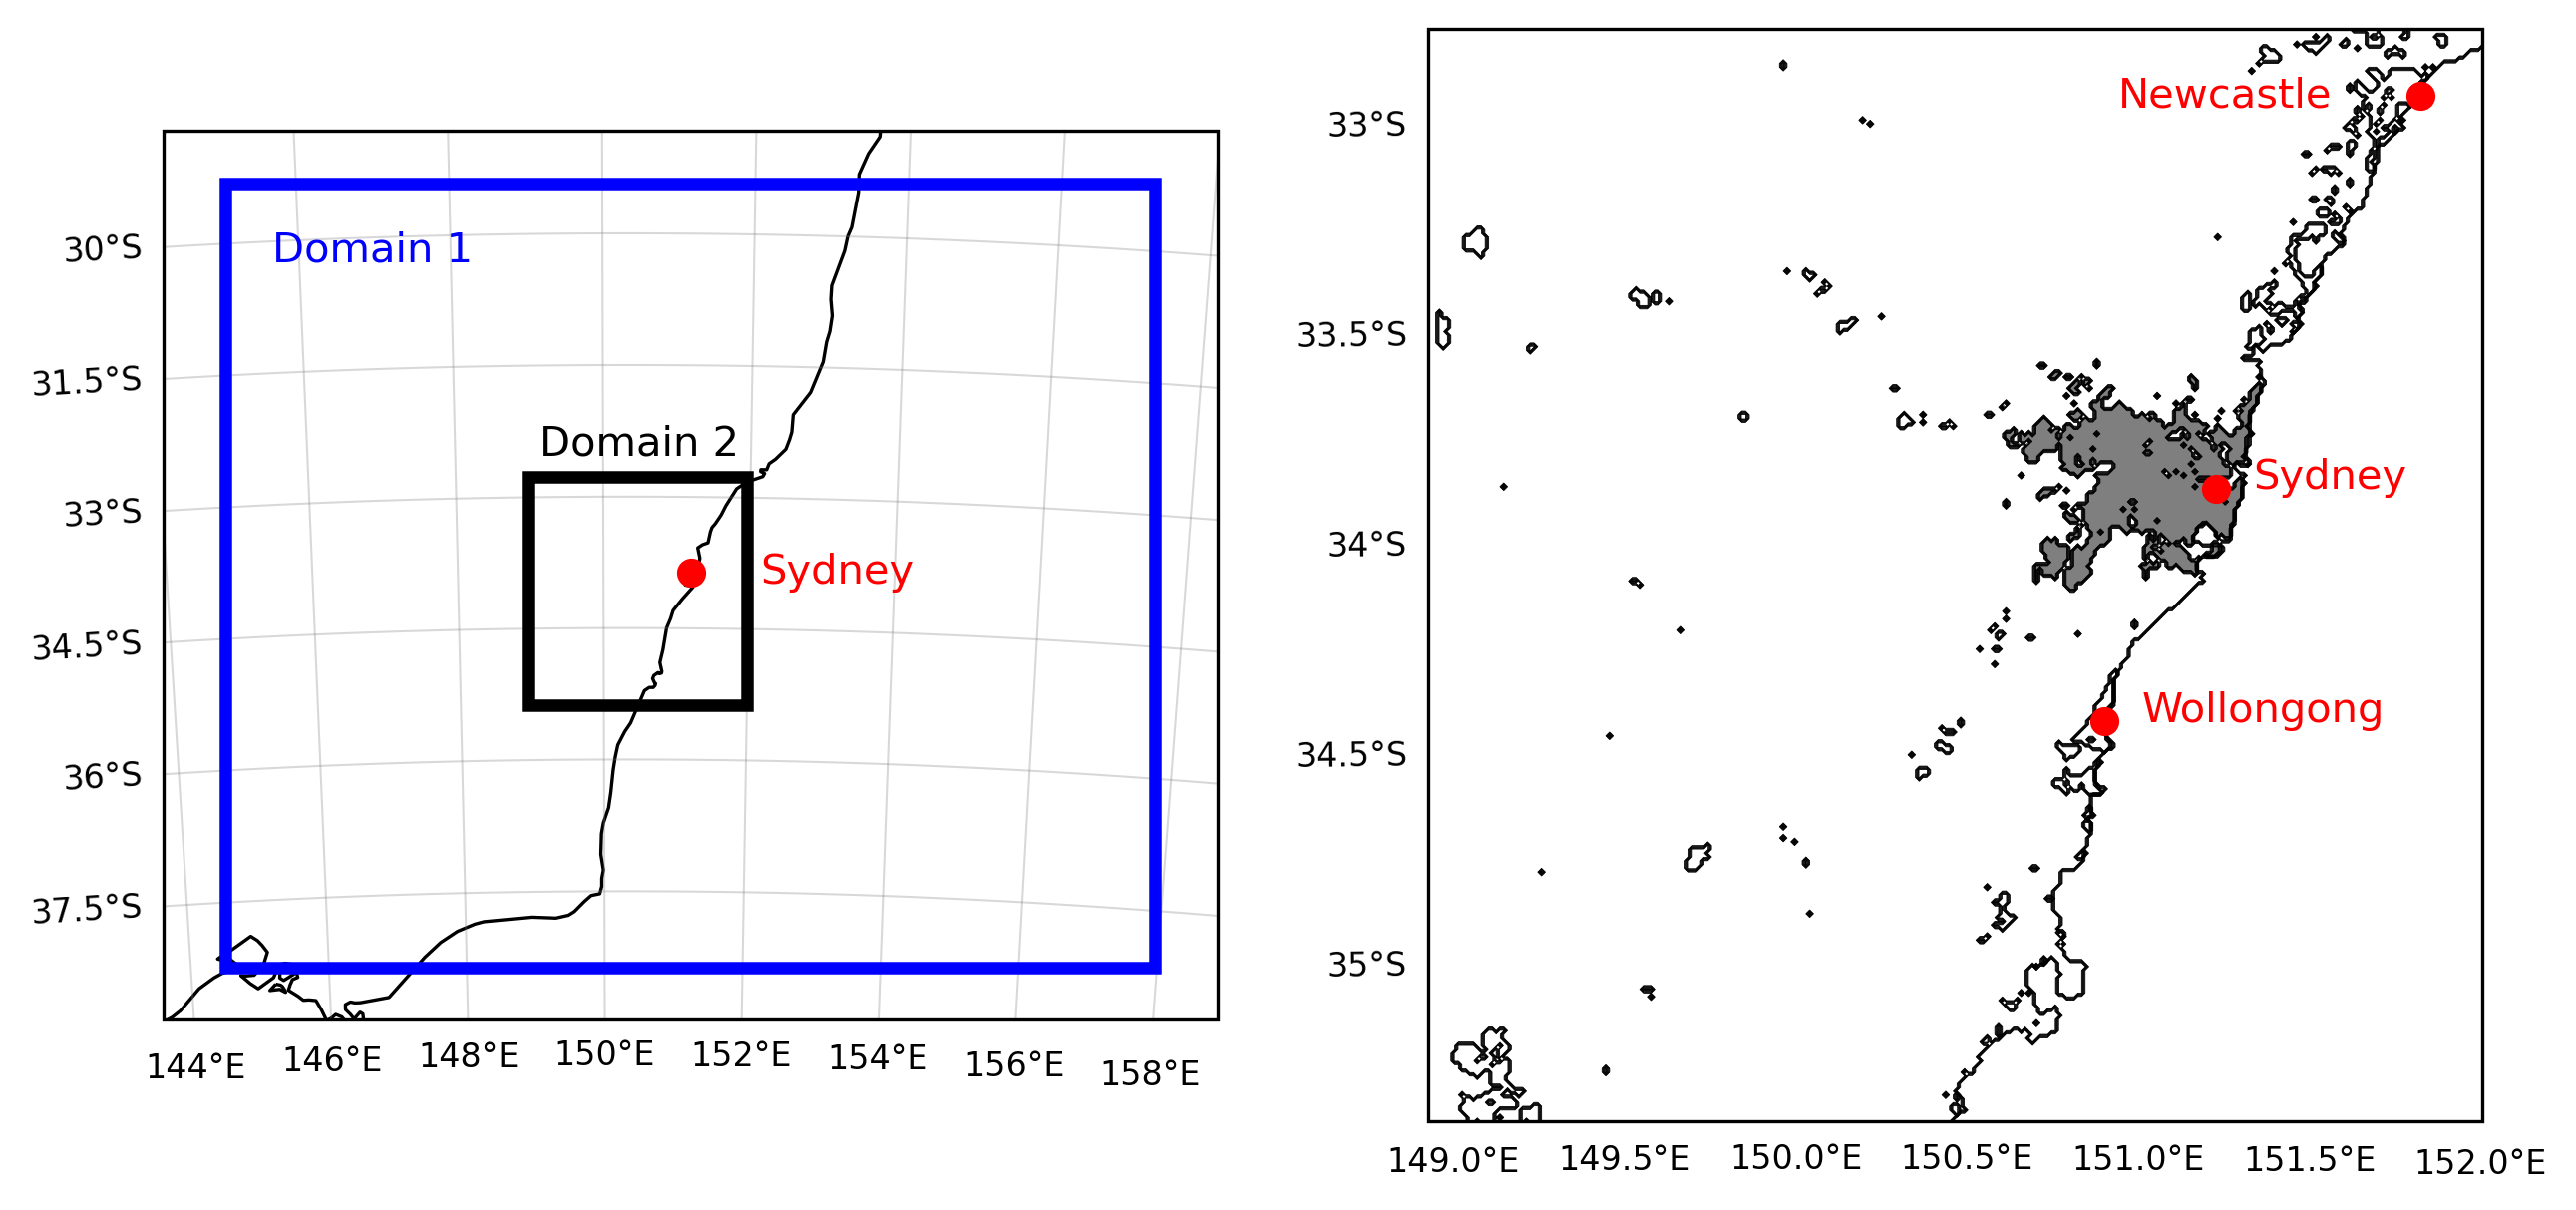

In [ ]:
# Code for nested domain modified from: 
# https://wolfscie.wordpress.com/2017/10/05/visualizing-wrf-domain/

grland = wrf.getvar(data_24_gr, 'LU_INDEX', timeidx=8, method='cat')

# defining the latitude and longitude of the plotted cities
syd_lat = -33.8688
syd_lon = 151.2093

wol_lat = -34.4248
wol_lon = 150.8931

new_lat = -32.9283
new_lon = 151.7817

lats, lons = wrf.latlon_coords(grland)
cart_proj = wrf.get_cartopy(grland)

# converting the city coordinates to the wrf grids
xy_sydney = cart_proj.transform_point(syd_lon, syd_lat, crs.PlateCarree())
xy_wollongong = cart_proj.transform_point(wol_lon, wol_lat, crs.PlateCarree())
xy_newcastle = cart_proj.transform_point(new_lon, new_lat, crs.PlateCarree())

cmapb = (mpl.colors.ListedColormap(['black']))
cmapb.set_bad(alpha=0)
bounds = [49,60]
norm = mpl.colors.BoundaryNorm(bounds, cmapb.N)
 
def get_plot_element(infile):
    rootgroup = nc.Dataset(infile, 'r')
    p = wrf.getvar(rootgroup, 'U10')
    cart_proj = wrf.get_cartopy(p)
    xlim = wrf.cartopy_xlim(p)
    ylim = wrf.cartopy_ylim(p)
    rootgroup.close()
    return cart_proj, xlim, ylim
 
infile_d01 = '/g/data/li18/em3807_2/WRF/WRF/run/wrfinput_d01'
cart_proj, xlim_d01, ylim_d01 = get_plot_element(infile_d01)
 
infile_d02 = '/g/data/li18/em3807_2/WRF/WRF/run/wrfinput_d02'
_, xlim_d02, ylim_d02 = get_plot_element(infile_d02)
 
 
fig, axs = plt.subplots(ncols=2,nrows=1, subplot_kw={'projection': cart_proj}, figsize=(10,8), dpi = 300)
axs[0].coastlines('50m', linewidth=0.8)
# outlining domain 1
axs[0].set_xlim([xlim_d01[0]-(xlim_d01[1]-xlim_d01[0])/15, xlim_d01[1]+(xlim_d01[1]-xlim_d01[0])/15])
axs[0].set_ylim([ylim_d01[0]-(ylim_d01[1]-ylim_d01[0])/15, ylim_d01[1]+(ylim_d01[1]-ylim_d01[0])/15])
 
axs[0].add_patch(mpl.patches.Rectangle((xlim_d01[0], ylim_d01[0]), xlim_d01[1]-xlim_d01[0], ylim_d01[1]-ylim_d01[0],
             fill=None, lw=3, edgecolor='blue', zorder=10))
axs[0].text(xlim_d01[0]+(xlim_d01[1]-xlim_d01[0])*0.05, ylim_d01[0]+(ylim_d01[1]-ylim_d01[0])*0.9, 'Domain 1',
        size=10, color='blue', zorder=10)
# outlining domain 2
axs[0].add_patch(mpl.patches.Rectangle((xlim_d02[0], ylim_d02[0]), xlim_d02[1]-xlim_d02[0], ylim_d02[1]-ylim_d02[0],
             fill=None, lw=3, edgecolor='black', zorder=10))
axs[0].text(xlim_d02[0]+(xlim_d02[1]-xlim_d02[0])*0.05, ylim_d02[0]+(ylim_d02[1]-ylim_d02[0])*1.1, 'Domain 2',
        size=10, color='black', zorder=10)
# plotting Sydney's location
axs[0].plot(xy_sydney[0], xy_sydney[1], 'ro', markersize=6, label='Sydney')
axs[0].text(170000, -10000, 'Sydney',
        size=10, color='red', zorder=10)
# labelling longitudes
gl = axs[0].gridlines(crs=crs.PlateCarree(), draw_labels=False,
                      linewidth=0.5, color='gray', alpha=0.3, linestyle='-')
gl.bottom_labels = True
gl.left_labels = True
gl.xlabel_style = dict(fontsize=8)
gl.ylabel_style = dict(fontsize=8)
longitudes = np.arange(144, 159, 2)
for lon in longitudes:
    lat_for_label = wrf.to_np(lats).min() - 3.8  # slightly below domain
    x, y = cart_proj.transform_point(lon, lat_for_label, crs.PlateCarree())

    axs[0].text(
        x, y,
        f"{lon}°E",
        ha='center',
        va='top',
        fontsize=8,
        zorder=20
    )
met_mask = np.ma.masked_where(met_outline() == 0, met_outline())
# plotting domain 2
axs[1].set_xlim(wrf.cartopy_xlim(grland))
axs[1].set_ylim(wrf.cartopy_ylim(grland))
axs[1].contour(wrf.to_np(lons), wrf.to_np(lats), gr_coastline(), 
                transform=crs.PlateCarree(), cmap=cmapb, linewidths = 0.2)
axs[1].pcolormesh(wrf.to_np(lons), wrf.to_np(lats), met_mask, 
                transform=crs.PlateCarree(), cmap=plt.colormaps['Greys_r'], alpha = 0.5)
axs[1].contour(wrf.to_np(lons), wrf.to_np(lats), urb_outline(), 
                transform=crs.PlateCarree(), cmap=cmapb, linewidths = 0.2)
# labelling cities
axs[1].plot(xy_sydney[0], xy_sydney[1], 'ro', markersize=6, label='Sydney')
axs[1].text(xy_sydney[0]+10000, xy_sydney[1], 'Sydney',
        size=10, color='red', zorder=10)
axs[1].text(xy_wollongong[0]+10000, xy_wollongong[1], 'Wollongong',
        size=10, color='red', zorder=10)
axs[1].text(xy_newcastle[0]-80000, xy_newcastle[1]-3000, 'Newcastle',
        size=10, color='red', zorder=10)
axs[1].plot(xy_wollongong[0], xy_wollongong[1], 'ro', markersize=6, label='Wollongong')
axs[1].plot(xy_newcastle[0], xy_newcastle[1], 'ro', markersize=6, label='Newcastle')
# Labelling longitudes
gl = axs[1].gridlines(crs=crs.PlateCarree(), draw_labels=False,
                      linewidth=0.5, color='gray', alpha=0, linestyle='-')
gl.bottom_labels = True
gl.left_labels = True
gl.xlabel_style = dict(fontsize=8)
gl.ylabel_style = dict(fontsize=8)
longitudes = np.arange(149, 152.5, 0.5)
for lon in longitudes:
    lat_for_label = wrf.to_np(lats).min() - 0.05  # slightly below domain
    x, y = cart_proj.transform_point(lon, lat_for_label, crs.PlateCarree())

    axs[1].text(
        x, y,
        f"{lon}°E",
        ha='center',
        va='top',
        fontsize=8,
        zorder=20
    )
plt.show()


### Surface roughness plots

In [13]:
sr_gr = Dataset('/g/data/li18/em3807_2/WRF_runs/extracted_data/NoUCM_GrUrban_land.nc')
sr_def = Dataset('/g/data/li18/em3807_2/WRF_runs/extracted_data/NoUCM_WRFDef_land.nc')
sr_nat = Dataset('/g/data/li18/em3807_2/WRF_runs/extracted_data/Natland_land.nc')
sr_grurb = Dataset('/g/data/li18/em3807_2/WRF_runs/extracted_data/BEPBEM_GrUrban_land.nc')
sr_defurb = Dataset('/g/data/li18/em3807_2/WRF_runs/extracted_data/BEPBEM_WRFDef_land.nc')
sr_crop = Dataset('/g/data/li18/em3807_2/WRF_runs/extracted_data/Cropland_land.nc')

en = [sr_crop, sr_def, sr_gr, sr_nat, sr_defurb, sr_grurb]
names = ['Cropland' ,'Default No-UCM', 'Gridded No-UCM', 'Forest', 'Default BEP-BEM', 'Gridded BEP-BEM']

sr_list = []

for caseind in range(len(en)):
    surf_rough = wrf.getvar(en[caseind], 'ZNT', timeidx = 0, method = 'cat')
    sr_list.append(surf_rough)

# extracting variables from wrf input file
input = Dataset('/g/data/li18/em3807_2/WRF/WRF/run/wrfinput_d02')
h = wrf.getvar(input,'BUILD_HEIGHT', timeidx = 0)
lambda_p = wrf.getvar(input,'BUILD_AREA_FRACTION', timeidx = 0)
build_surf = wrf.getvar(input,'BUILD_SURF_RATIO', timeidx = 0)
# estimating lambda_f from wrf variables
a_w = build_surf-lambda_p
lambda_f = (a_w/4)
# defining constants
a = 4.43
beta = 1
c_d = 1.2
kappa = 0.4
# calculating roughness length
z_d = (1+a**(-lambda_p)*(lambda_p-1))*h
z_0 = ((1-z_d/h)*np.exp(-(0.5*beta*(c_d/(kappa**2))*(1-z_d/h)*lambda_f)**(-0.5)))*h
# filling in missing values over the urban area
z0 = z_0.where(~xr.ufuncs.isnan(z_0), 0)

# only plotting calculated roughness over the urban area in WRF (where it is used)
grland = wrf.getvar(input, 'LU_INDEX', timeidx=0, method='cat')
urb = np.where(grland <= 49, 0, grland) #set everything that isn't urban to zero
uniurb = np.where(urb >= 49, 1, urb) #make urban area uniform so
grurb = np.where(uniurb==0, sr_list[2], z0)
defurb = np.where(sr_list[4] == 0.14, 1.5, sr_list[4])
sr_list[5] = grurb
sr_list[4] = defurb

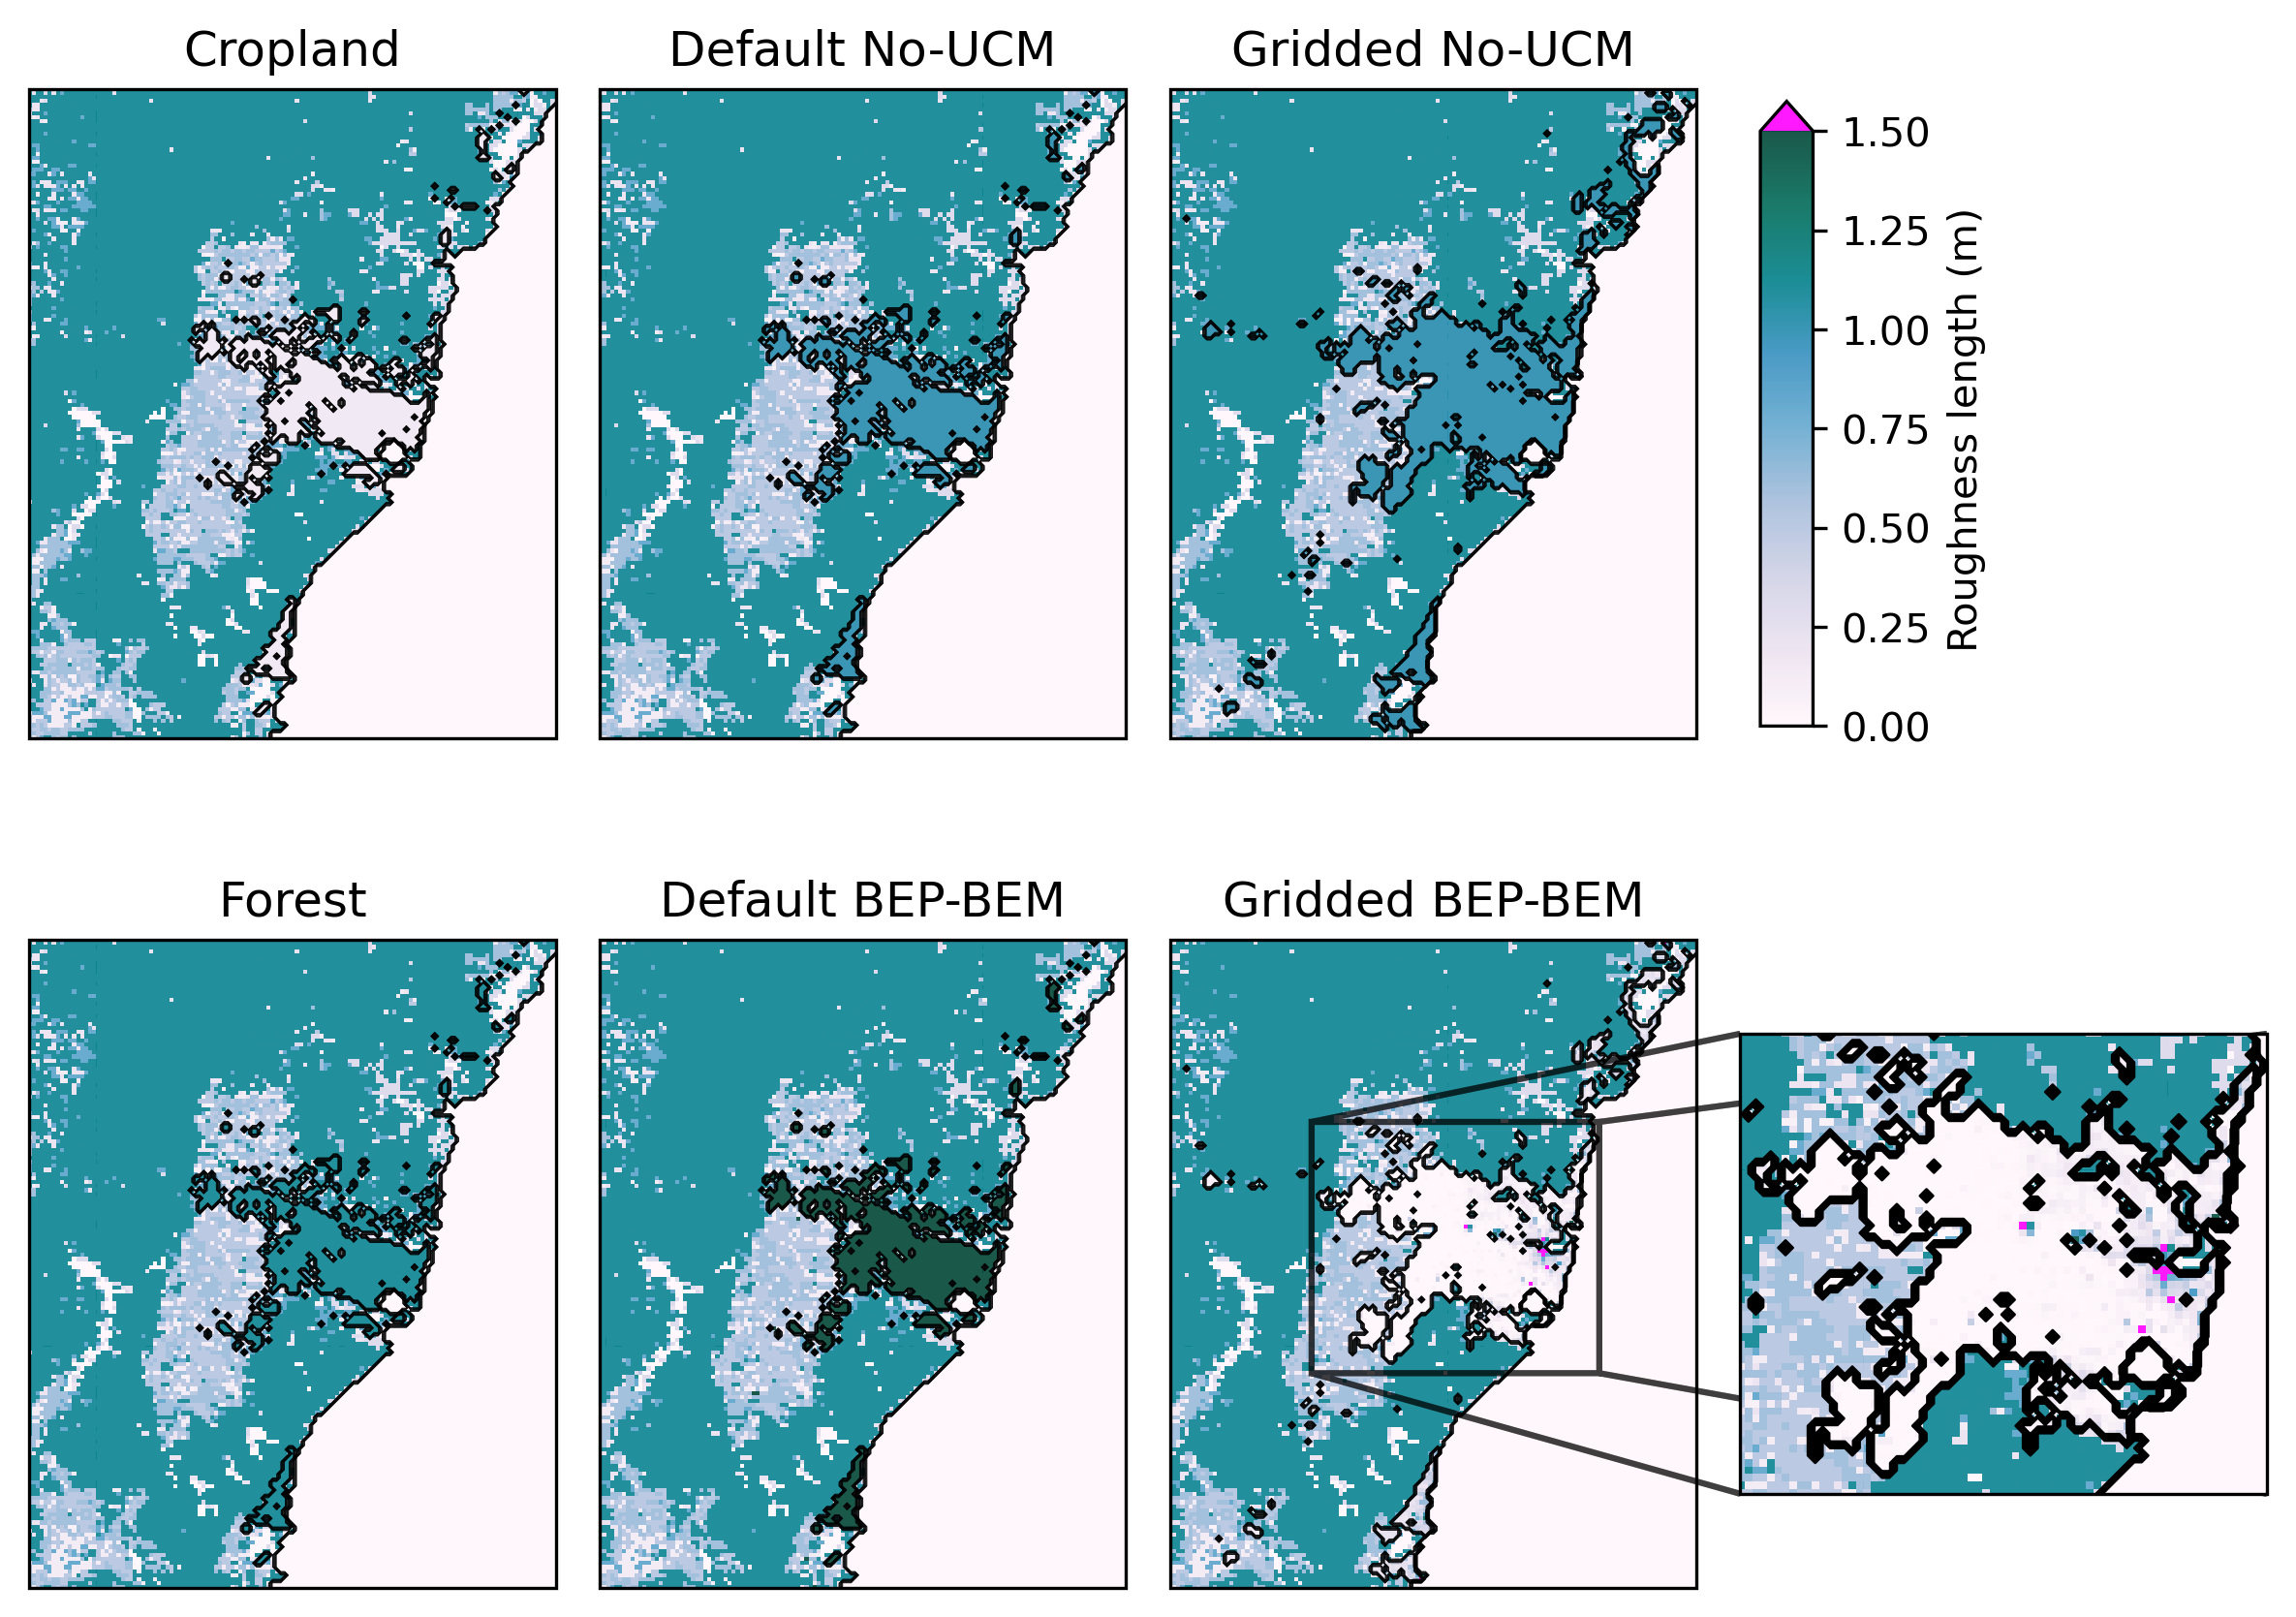

In [20]:
# extracting latitude and longitude
z_plot = sr_list[0]
lats, lons = wrf.latlon_coords(z_plot)
cart_proj = wrf.get_cartopy(z_plot)

# defining colormaps
cmapb = (mpl.colors.ListedColormap(['black']))
cmapb.set_bad(alpha=0)
bounds = [49,60]
norm = mpl.colors.BoundaryNorm(bounds, cmapb.N)
cmap = plt.get_cmap('PuBuGn')
cmap.set_extremes(over='magenta')
norm2 = colors.Normalize(vmin=0, vmax=1.5)

# setting up figure axes
fig = plt.figure(figsize=(8,8), dpi=300)
gs = gridspec.GridSpec(nrows=2, ncols=4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=cart_proj)
ax2 = fig.add_subplot(gs[0, 1], projection=cart_proj)
ax3 = fig.add_subplot(gs[0, 2], projection=cart_proj)
ax4 = fig.add_subplot(gs[1, 0], projection=cart_proj)
ax5 = fig.add_subplot(gs[1, 1], projection=cart_proj)
ax6 = fig.add_subplot(gs[1, 2], projection=cart_proj)
ax7 = fig.add_subplot(gs[1, 3], projection=cart_proj)
ax8 = fig.add_subplot(gs[0, 3], projection=cart_proj)
plt.tight_layout()
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7,ax8]

# defining limits for the zoomed in plot for the gridded dataset
zoom_xlim = (25000, 96000)
zoom_ylim = (-27000, 35000)

# making the surface roughness plots
for ind in range(len(sr_list)+1):
        if ind < len(sr_list):
                current_ax = axs[ind]
                nat1 = current_ax.pcolormesh(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(sr_list[ind]),
                                transform=crs.PlateCarree(), cmap=cmap, alpha = 0.9, norm=norm2)
                current_ax.set_title(names[ind])
                current_ax.set_xlim(wrf.cartopy_xlim(z_plot))
                current_ax.set_ylim(wrf.cartopy_ylim(z_plot))
                if ind == 2 or ind == 5:
                        current_ax.contour(wrf.to_np(lons), wrf.to_np(lats), urb_outline(), 
                        transform=crs.PlateCarree(), cmap=cmapb, linewidths=0.2)
                else:
                        current_ax.contour(wrf.to_np(lons), wrf.to_np(lats), def_urb_outline(), 
                        transform=crs.PlateCarree(), cmap=cmapb, linewidths=0.2)
                current_ax.contour(wrf.to_np(lons), wrf.to_np(lats), gr_coastline(), 
                        transform=crs.PlateCarree(), cmap=cmapb, linewidths=0.2)
                current_ax.set_xlim(-10000, 120000)
                current_ax.set_ylim(-80000, 80000)  
        if current_ax == axs[5]:
                inset_ax = axs[6]
                parent_ax = axs[5]
                indicator = parent_ax.indicate_inset_zoom(inset_ax, edgecolor='k', linewidth=1.5, linestyle='-')
                for conn in indicator.connectors:
                        conn.set_visible(True)     
arr_zoom = sr_list[5]
a_zoom = axs[6]
pcm_zoom = a_zoom.pcolormesh(
    wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(arr_zoom),
    transform=crs.PlateCarree(),cmap=cmap, alpha = 0.9, norm=norm2)
a_zoom.set_xlim(zoom_xlim)
a_zoom.set_ylim(zoom_ylim)
a_zoom.contour(
    wrf.to_np(lons), wrf.to_np(lats), urb_outline(),
    transform=crs.PlateCarree(), colors='k', linewidths=0.6
)
a_zoom.contour(
    wrf.to_np(lons), wrf.to_np(lats), gr_coastline(),
    transform=crs.PlateCarree(), colors='k', linewidths=0.6
)
ticks = [0,0.25,0.5,0.75,1.0,1.25,1.5]
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# clearing the extra plot for the colorabr
axs[7].set_facecolor('none') 
for spine in axs[7].spines.values():
    spine.set_visible(False)
axs[7].set_xticks([])
axs[7].set_yticks([])
axs[7].set_zorder(1) 

cbar_ax = inset_axes(
    axs[7],
    width="10%",   
    height="200%",
    loc="center left"
)
cbar_ax.set_zorder(10) 
cbar_ax.patch.set_alpha(1.0)

cbar = fig.colorbar(nat1, cax=cbar_ax, ticks=ticks, extend='max')
cbar.set_label("Roughness length (m)")


### Building Drag Coefficient plots

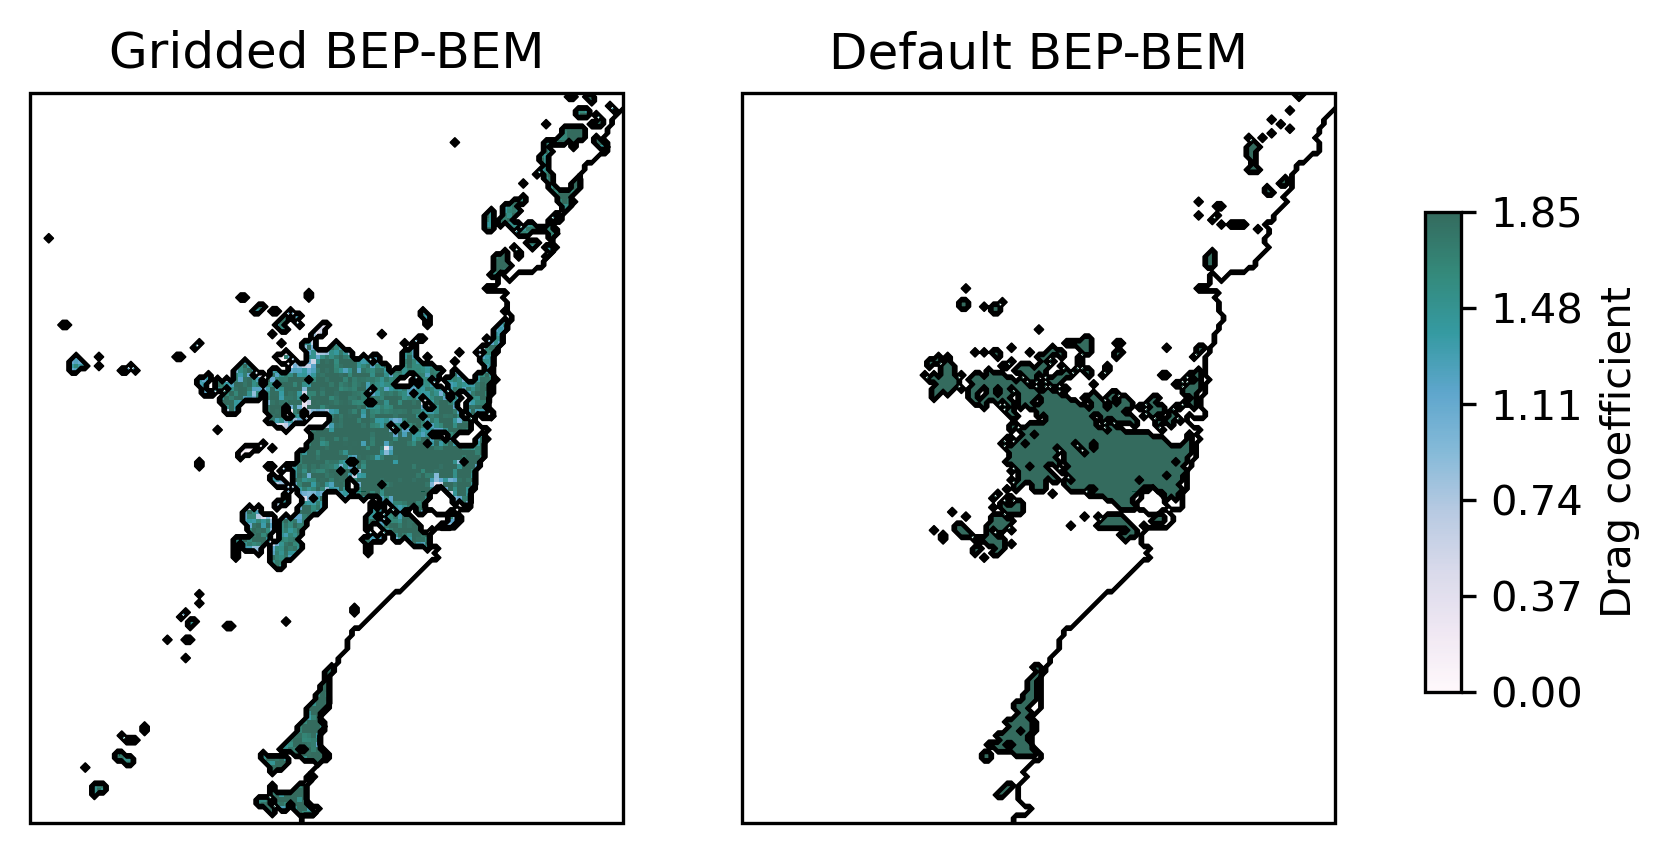

In [ ]:
# extracting build area fraction to calculate drag coefficient
urb_drag = Dataset('/g/data/li18/em3807_2/WRF/WRF/run/wrfinput_d02')
lambda_p = wrf.getvar(urb_drag, 'BUILD_AREA_FRACTION', timeidx=0, method='cat')

# calculating drag coefficient
drag = np.where(lambda_p > 0.29, 1.85, 3.32*lambda_p**0.47)
# for gridded land surface only plotting drag coefficient over the urban area
drag = np.ma.masked_where(urb_outline() <= 0, drag)

# for default land surface defining drag coefficient
drag_d = np.where(def_urb_outline()==1, 1.85, 0)
drag_def = np.ma.masked_where(drag_d == 0, drag_d)

# making colormap for urban outline
cmapb = (mpl.colors.ListedColormap(['black']))
cmapb.set_bad(alpha=0)
bounds = [0,1]
norm = mpl.colors.BoundaryNorm(bounds, cmapb.N)

# defining figure and axes
lats, lons = wrf.latlon_coords(lambda_p)
cart_proj = wrf.get_cartopy(lambda_p)
fig, axs = plt.subplots(ncols=2,nrows=1, subplot_kw={'projection': cart_proj}, figsize=(6,4), dpi=300)

# plotting gridded drag coefficient
drag1 = axs[0].pcolormesh(wrf.to_np(lons), wrf.to_np(lats), drag, alpha = 0.8,
                transform=crs.PlateCarree(), cmap=plt.colormaps['PuBuGn'], vmax = 1.85)

axs[0].contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(urb_outline()), 
                transform=crs.PlateCarree(), cmap=cmapb, linewidths = 0.4) # plot after the colourmap is made
axs[0].contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(gr_coastline()), 
                transform=crs.PlateCarree(), cmap=cmapb, linewidths = 0.4) 

axs[0].set_xlim((-10000,120000))
axs[0].set_ylim((-80000,80000))
axs[0].set_title('Gridded BEP-BEM')

# plotting default drag coefficient
axs[1].pcolormesh(wrf.to_np(lons), wrf.to_np(lats), drag_def, alpha = 0.8,
                transform=crs.PlateCarree(), cmap=plt.colormaps['PuBuGn'], vmax = 1.85, vmin = 0)

axs[1].contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(def_urb_outline()), 
                transform=crs.PlateCarree(), cmap=cmapb, linewidths = 0.4) # plot after the colourmap is made
axs[1].contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(gr_coastline()), 
                transform=crs.PlateCarree(), cmap=cmapb, linewidths = 0.4) 

axs[1].set_xlim((-10000,120000))
axs[1].set_ylim((-80000,80000))
axs[1].set_title('Default BEP-BEM')

# placing colourbar
fig.subplots_adjust(right=0.85) # position of the right edge of the subplots
cbar_ax = fig.add_axes([0.9, 0.3, 0.02, 0.4]) #left, bottom, width, height
cbar = fig.colorbar(drag1, cax=cbar_ax, ticks=[0, 0.37, 0.74, 1.11, 1.48, 1.85])
cbar.set_label("Drag coefficient")

### MODIS land surface plots

In [ ]:
# loading in data for land surface plots
def dataset_files(setup, run_no, year, file = True):
    year_dict = {
        2017: ['16_00', '15_23', '15_22', '15_21', '15_20', '2017-02'],
        2018: ['18_00', '17_23', '17_22', '17_21', '17_20', '2018-12'],
        2020: ['15_00', '14_23', '14_22', '14_21', '14_20', '2020-12'],
        2024: ['11_00', '10_23', '10_22', '10_21', '10_20', '2024-02'],
    }
    if file:
        t = year_dict[year][run_no-1]
        t_ind = int(t[0:2])
        t2 = str(t_ind+1)+t[2:]
        t3 = str(t_ind+2)+t[2:]
        if run_no == 1:
            dat = [Dataset(f'/g/data/li18/em3807_2/WRF_runs/{setup}_{year}/wrfout_d02_{year_dict[year][5]}-{t}:00:00'),
            Dataset(f'/g/data/li18/em3807_2/WRF_runs/{setup}_{year}/wrfout_d02_{year_dict[year][5]}-{t2}:00:00'),
            Dataset(f'/g/data/li18/em3807_2/WRF_runs/{setup}_{year}/wrfout_d02_{year_dict[year][5]}-{t2}:10:00'),
            Dataset(f'/g/data/li18/em3807_2/WRF_runs/{setup}_{year}/wrfout_d02_{year_dict[year][5]}-{t3}:10:00')]
        else:
            hour = t[3:5]
            dat = [Dataset(f'/g/data/li18/em3807_2/WRF_runs/{setup}_{year}_{str(run_no)}/wrfout_d02_{year_dict[year][5]}-{t}:00:00'),
            Dataset(f'/g/data/li18/em3807_2/WRF_runs/{setup}_{year}_{str(run_no)}/wrfout_d02_{year_dict[year][5]}-{t2}:00:00'),
            Dataset(f'/g/data/li18/em3807_2/WRF_runs/{setup}_{year}_{str(run_no)}/wrfout_d02_{year_dict[year][5]}-{t2}:10:00'),
            Dataset(f'/g/data/li18/em3807_2/WRF_runs/{setup}_{year}_{str(run_no)}/wrfout_d02_{year_dict[year][5]}-{t3}:10:00')]
        return(dat)
    else:
        if run_no == 1:
            dat = Dataset(f'/g/data/li18/em3807_2/WRF_runs/extracted_data/{setup}_{year}_subset.nc')
        else:
            dat = Dataset(f'/g/data/li18/em3807_2/WRF_runs/extracted_data/{setup}_{year}_{run_no}_subset.nc')
        return(dat)
data_24_crop = dataset_files('Cropland', 1, 2024)
data_24_noeuro = dataset_files('Pre_Euro', 1, 2024)
data_24_nat = dataset_files('Natland', 1, 2024)
data_24_def = dataset_files('NoUCM_WRFDef', 1, 2024)
data_24_defurb = dataset_files('BEPBEM_WRFDef', 1, 2024)
data_24_grurb = dataset_files('BEPBEM_GrUrban', 1, 2024)
data_24_gr = dataset_files('NoUCM_GrUrban', 1, 2024)

# extracting land use index
en = [data_24_crop, data_24_noeuro, data_24_nat, data_24_def,data_24_gr]
names = ['Cropland', 'Pre-European', 'Forest', 'Default', 'Gridded']
hal = wrf.getvar(en[0], 'HAIL_MAXK1', timeidx=0, method='cat')  # for metadata
hail_list = []

for caseind in range(len(names)):
    hail = wrf.getvar(en[caseind], 'LU_INDEX', timeidx=0, method='cat')
    hail_list.append(hail)

# ordering the data for plotting
plot_list = [hail_list[3],hail_list[2],hail_list[0],hail_list[1],hail_list[4]]
names = ['Default', 'Forest', 'Pre-European', 'Cropland', 'Gridded']

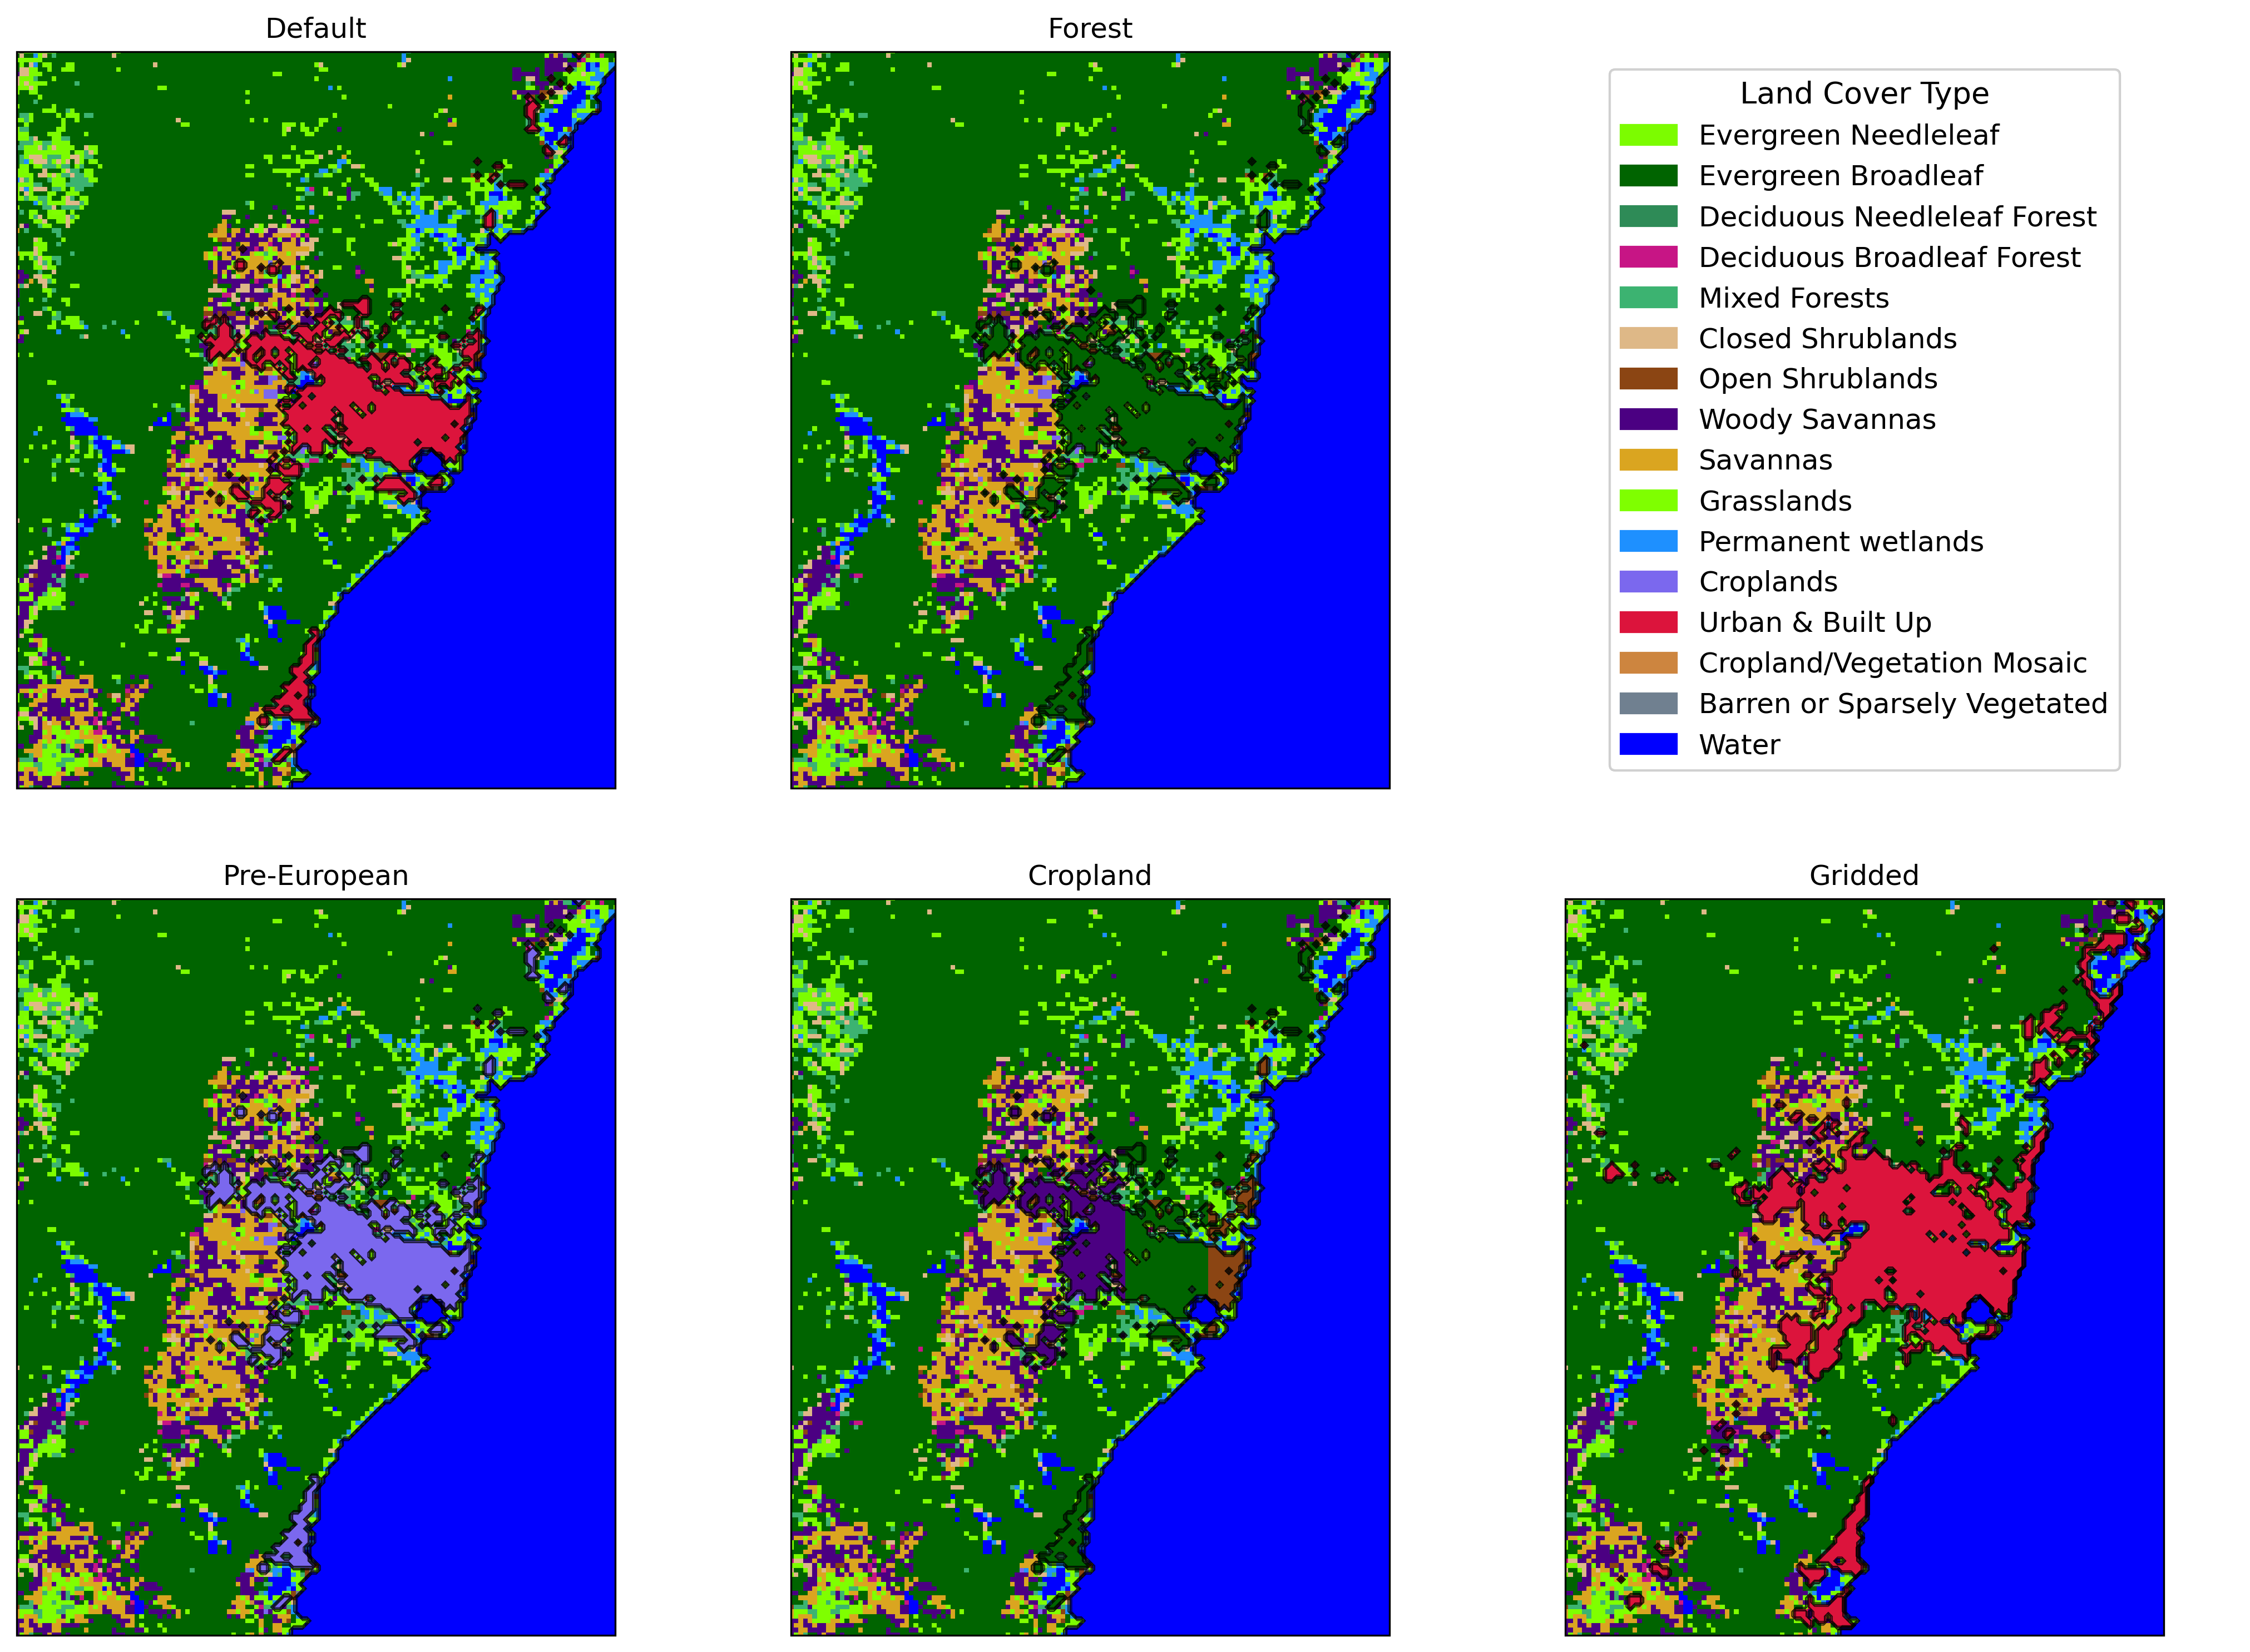

In [ ]:
mapcolours = []
# matching LU_INDEX to MODIS land type categories
lu_labels = {
    1: ['Evergreen Needleleaf', 'lawngreen'],
    2: ['Evergreen Broadleaf', 'darkgreen'], 
    3: ['Deciduous Needleleaf Forest', 'seagreen'],
    4: ['Deciduous Broadleaf Forest', 'mediumvioletred'],
    5: ['Mixed Forests', 'mediumseagreen'],
    6: ['Closed Shrublands', 'burlywood'],
    7: ['Open Shrublands', 'saddlebrown'],
    8: ['Woody Savannas', 'indigo'],
    9: ['Savannas', 'goldenrod'],
    10: ['Grasslands', 'chartreuse'],
    11: ['Permanent wetlands', 'dodgerblue'],
    12: ['Croplands', 'mediumslateblue'],
    13: ['Urban & Built Up', 'crimson'], 
    14: ['Cropland/Vegetation Mosaic', 'peru'],
    16: ['Barren or Sparsely Vegetated', 'slategray'],
    17: ['Water', 'blue'],  
    51: ['Urban', 'crimson'], # the following are LCZ urban categories not used in our simulations
    52: ['Urban', 'crimson'], # therefore all urban types are set to a single category like they are seen by the model
    53: ['Urban', 'crimson'],
    54: ['Urban', 'crimson'],
    55: ['Urban', 'crimson'],
    56: ['Urban', 'crimson'],
    57: ['Urban', 'crimson'],
    58: ['Urban', 'crimson'],
    59: ['Urban', 'crimson'],
    60: ['Urban', 'crimson']
}

for element in lu_labels.keys():
        mapcolours.append(lu_labels[element][1])

cmap = ListedColormap(mapcolours)

bounds2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
norm = mpl.colors.BoundaryNorm(bounds2, cmap.N)

# making axes for plotting
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 10), subplot_kw={'projection': cart_proj}, dpi=300)

ax[0, 2].axis('off')

for ind in range(5):
    if ind < 2:
        row, col = (0, ind)
    else:
        row, col = (1, ind - 2)
    arr = plot_list[ind]
    a = ax[row, col]
    pcm = a.pcolormesh(
        wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(arr),
        transform=crs.PlateCarree(), cmap=cmap, norm=norm
    )
    a.set_title(names[ind])
    a.set_xlim(-10000, 120000)
    a.set_ylim(-80000, 80000)
    if ind == 4:
        a.contour(
        wrf.to_np(lons), wrf.to_np(lats), urb_outline(),
        transform=crs.PlateCarree(), colors='k', linewidths=0.2
    )
    else:
        a.contour(
        wrf.to_np(lons), wrf.to_np(lats), def_urb_outline(),
        transform=crs.PlateCarree(), colors='k', linewidths=0.2
    )
    a.contour(
        wrf.to_np(lons), wrf.to_np(lats), gr_coastline(),
        transform=crs.PlateCarree(), colors='k', linewidths=0.2
    )


landtypes = []
for element in lu_labels.keys():
    if element < 51:  # for non-urban categories, use the original labels
        patch = mpl.patches.Patch(color=lu_labels[element][1], label=lu_labels[element][0])
    landtypes.append(patch)


ax[0, 2].axis('off')
ax[0, 2].set_facecolor('white')

land_legend = ax[0, 2].legend(handles=landtypes[:16], title="Land Cover Type", 
                              loc='center', fontsize=12,title_fontsize=13) #bbox_to_anchor=(0, 1.3)

ax[0, 2].add_artist(land_legend)


plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.show()